In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from hyperopt import hp

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
data, y = make_regression(
    n_samples=500, n_features=4, n_informative=2, noise=10)
data = pd.DataFrame(data=data, columns=['f'+str(i+1) for i in range(data.shape[1])])
# adding some non-linearity
y = (y + abs(y.min())) ** 2
y /= 1000

features = [c for c in data.columns]
train, test, ytrain, ytest = train_test_split(data[features], y, test_size=0.25)

scaler = StandardScaler()
train = pd.DataFrame(data=scaler.fit_transform(train),  columns=features)
test  = pd.DataFrame(data=scaler.transform(test),  columns=features)

# XGB tuning

In [3]:
# Define parameters space for hyperopt to search 
base_params = {
    'objective': 'reg:linear',
    'eval_metric': 'rmse', 
    'booster': 'gbtree',
    'tree_method':'hist',
    'learning_rate': 0.05
}
tunable_params = {
    'max_depth'         :hp.quniform('max_depth',   2, 12, 1),
    'max_bin'           :hp.quniform('max_bin', 20, 351, 20),

    'colsample_bytree'  :hp.uniform ('colsample_bytree', 0.5, 1),
    'colsample_bylevel' :hp.uniform ('colsample_bylevel',0.5, 1),
#     'scale_pos_weight'  :hp.uniform ('scale_pos_weight', 1, 10),

    'min_child_weight'  :hp.loguniform('min_child_weight', 0, 5),
    'gamma'             :hp.loguniform('gamma',  0, 3),
    'alpha'             :hp.loguniform('alpha',  0, 3),
    'lambda'            :hp.loguniform('lambda', 0, 3)
}
# Hyperopt returns params in float form, which is
# unacceptable for some parameters of model.
# integer_params will be transformed to ints.
integer_params = ['max_depth', 'max_bin']

In [4]:
from tuner import Tuner
TT = Tuner(
    train=train, ytrain=ytrain,
    model='xgb', maximize=False,
    base_params=base_params,
    tunable_params=tunable_params,
    integer_params=integer_params,
    n_splits=3, stratify=False, split_seed=0 
)

In [5]:
TT.tune(trials_to_to=[20, 7, 3])

Started 1 epoch of tuning
Default parameters score for current folds: 9.2963
20 trials are done in 1.1 minutes. Best metric achieved is 8.6828

Started 2 epoch of tuning
Default parameters score for current folds: 8.6593
7 trials are done in 0.5 minutes. Best metric achieved is 7.654

Started 3 epoch of tuning
Default parameters score for current folds: 9.2911
3 trials are done in 0.3 minutes. Best metric achieved is 7.8343



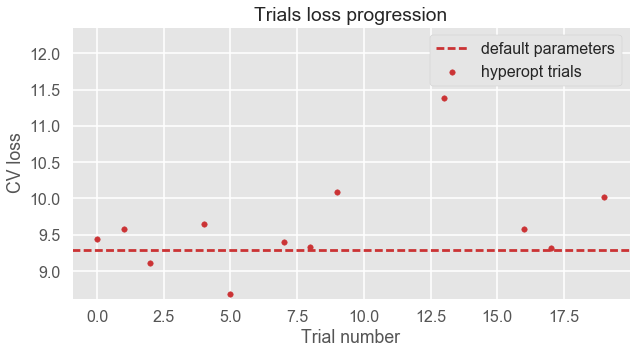

In [6]:
TT.plot_1_epoch_results()

In [7]:
TT.results.head(10)

,params,num_iters,checks,total_loss,1_epoch_loss,2_epoch_loss,3_epoch_loss
0,"{'objective': 'reg:linear', 'gamma': 1.4101654...",569,3,24.171047,8.682842,7.653953,7.834252
1,"{'objective': 'reg:linear', 'gamma': 3.2066548...",346,3,25.362177,9.113652,7.992191,8.256333
2,"{'objective': 'reg:linear', 'gamma': 7.6742131...",579,3,26.438900,9.314808,8.477483,8.646609
3,"{'objective': 'reg:linear', 'gamma': 5.3209412...",174,2,17.844000,9.396674,8.447326,0.000000
4,"{'objective': 'reg:linear', 'gamma': 8.7478886...",304,2,17.869230,9.577653,8.291577,0.000000
5,"{'objective': 'reg:linear', 'gamma': 20.002611...",278,2,18.109555,9.442479,8.667076,0.000000
6,"{'objective': 'reg:linear', 'gamma': 9.8492796...",287,2,18.224821,9.327036,8.897786,0.000000
7,"{'objective': 'reg:linear', 'gamma': 2.0652479...",283,1,9.585978,9.585978,0.000000,0.000000
8,"{'objective': 'reg:linear', 'gamma': 3.0619105...",240,1,9.644659,9.644659,0.000000,0.000000
9,"{'objective': 'reg:linear', 'gamma': 2.3281921...",444,1,10.021760,10.021760,0.000000,0.000000


In [21]:
best_parameters = TT.results.iloc[0].params
iters_number = TT.results.iloc[0].num_iters
print('Best parameters:')
print(best_parameters, '\n')
print('Number of trees for parameter set:', iters_number)

Best parameters:
{'objective': 'reg:linear', 'gamma': 1.4101654884674304, 'tree_method': 'hist', 'alpha': 2.3573632794528985, 'learning_rate': 0.05, 'max_bin': 180, 'booster': 'gbtree', 'min_child_weight': 1.5674221362829732, 'max_depth': 2, 'eval_metric': 'rmse', 'colsample_bylevel': 0.927783349214442, 'lambda': 4.36655877751855, 'colsample_bytree': 0.6108367265641477} 

Number of trees for parameter set: 569


In [12]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model = xgb.train(
    TT.results.sort_values('1_epoch_loss').iloc[0].params,
    xgb.DMatrix(train, ytrain),
    num_boost_round=TT.results.sort_values('1_epoch_loss').iloc[0].num_iters
)
print('Best model after first epoch on test:',
      mean_squared_error(ytest, model.predict(xgb.DMatrix(test))))

model = xgb.train(
    TT.results.iloc[0].params,
    xgb.DMatrix(train, ytrain),
    num_boost_round=TT.results.iloc[0].num_iters
)
print('Best model after all epochs on test:',
      mean_squared_error(ytest, model.predict(xgb.DMatrix(test))))

Best model after first epoch on test: 85.1778307053
Best model after all epochs on test: 85.1778307053


# LGB tuning

In [13]:
# Define parameters space for hyperopt to search 
base_params = {
    'metric': 'mse',
    'objective': 'mse',
    'learning_rate' : 0.05
}

tunable_params = {
    'num_leaves'        :hp.loguniform('num_leaves',  1.5, 7),
    'max_bin'           :hp.quniform('max_bin', 10, 400, 10),
    #'scale_pos_weight'  :hp.uniform ('scale_pos_weight', 1, 20),

    'feature_fraction'  :hp.uniform ('feature_fraction', 0.5, 1),
    'bagging_fraction'  :hp.uniform ('bagging_fraction', 0.5, 1),
    'bagging_freq'      :hp.quniform('bagging_freq', 0, 10, 1),

    'min_data_in_leaf'  :hp.loguniform('min_data_in_leaf', 1, 7),
    'min_split_gain'    :hp.loguniform('min_split_gain',  0, 5),
    'lambda_l2'         :hp.loguniform('lambda_l2',  0, 5),
    'lambda_l1'         :hp.loguniform('lambda_l1', 0, 5)
}

# Hyperopt returns params in float form, which is
# unacceptable for some parameters of model.
# integer_params will be transformed to ints.
integer_params = ['max_depth', 'max_bin', 'num_leaves', 'min_data_in_leaf', 'bagging_freq']

In [14]:
from tuner import Tuner
T = Tuner(
    train=train, ytrain=ytrain,
    model='lgb', maximize=False,
    base_params=base_params,
    tunable_params=tunable_params,
    integer_params=integer_params,
    n_splits=3, split_seed=0, stratify=False
)

In [15]:
T.tune(trials_to_to=[75, 25, 7])

Started 1 epoch of tuning
Default parameters score for current folds: 114.8065
75 trials are done in 1.2 minutes. Best metric achieved is 81.1083

Started 2 epoch of tuning
Default parameters score for current folds: 88.8378
25 trials are done in 0.5 minutes. Best metric achieved is 67.5459

Started 3 epoch of tuning
Default parameters score for current folds: 92.247
7 trials are done in 0.1 minutes. Best metric achieved is 67.1392



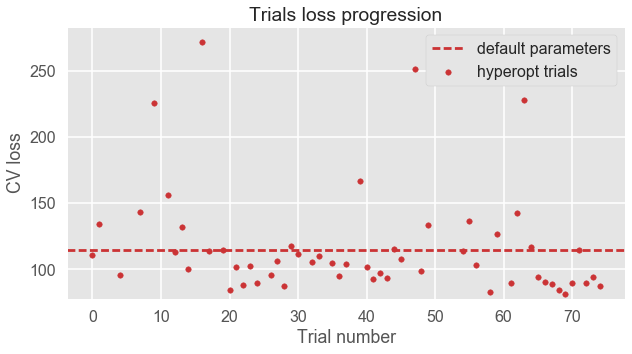

In [16]:
T.plot_1_epoch_results()

In [17]:
T.results.head(10)

,params,num_iters,checks,total_loss,1_epoch_loss,2_epoch_loss,3_epoch_loss
0,"{'num_leaves': 5, 'min_data_in_leaf': 9, 'obje...",211,3,217.522350,82.837312,67.545859,67.139179
1,"{'num_leaves': 4, 'min_data_in_leaf': 4, 'obje...",238,3,224.744764,81.108262,71.774945,71.861556
2,"{'num_leaves': 4, 'min_data_in_leaf': 3, 'obje...",179,3,225.050237,84.488844,68.172782,72.388612
3,"{'num_leaves': 6, 'min_data_in_leaf': 3, 'obje...",275,3,227.324537,84.085150,69.177505,74.061882
4,"{'num_leaves': 7, 'min_data_in_leaf': 4, 'obje...",158,3,233.442460,89.388507,72.365769,71.688184
5,"{'num_leaves': 6, 'min_data_in_leaf': 3, 'obje...",227,3,238.433542,87.610586,72.370052,78.452903
6,"{'num_leaves': 9, 'min_data_in_leaf': 8, 'obje...",202,3,239.897743,87.269883,74.830820,77.797041
7,"{'num_leaves': 787, 'min_data_in_leaf': 8, 'ob...",177,2,163.197647,89.761359,73.436288,0.000000
8,"{'num_leaves': 6, 'min_data_in_leaf': 10, 'obj...",230,2,163.503601,89.267424,74.236178,0.000000
9,"{'num_leaves': 8, 'min_data_in_leaf': 2, 'obje...",166,2,164.500165,88.394112,76.106053,0.000000


In [20]:
best_parameters = T.results.iloc[0].params
iters_number = T.results.iloc[0].num_iters
print('Best parameters:')
print(best_parameters, '\n')
print('Number of trees for parameter set:', iters_number)

Best parameters:
{'num_leaves': 5, 'min_data_in_leaf': 9, 'objective': 'mse', 'lambda_l2': 1.0034742455440055, 'lambda_l1': 5.085492576115697, 'max_bin': 255, 'min_split_gain': 9.389942510466074, 'feature_fraction': 0.8479765317644915, 'learning_rate': 0.05, 'metric': 'mse', 'bagging_freq': 2, 'bagging_fraction': 0.6407907430343374, 'verbose': 1} 

Number of trees for parameter set: 211


In [18]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

model = lgb.train(
    T.results.sort_values('1_epoch_loss').iloc[0].params,
    lgb.Dataset(train, ytrain),
    num_boost_round=T.results.sort_values('1_epoch_loss').iloc[0].num_iters
)
print('Best model after first epoch on test:', mean_squared_error(ytest, model.predict(test)))

model = lgb.train(
    T.results.iloc[0].params,
    lgb.Dataset(train, ytrain),
    num_boost_round=T.results.iloc[0].num_iters
)
print('Best model after all epochs on test:', mean_squared_error(ytest, model.predict(test)))

Best model after first epoch on test: 104.023259255
Best model after all epochs on test: 98.272942673
